[*********************100%%**********************]  1 of 1 completed


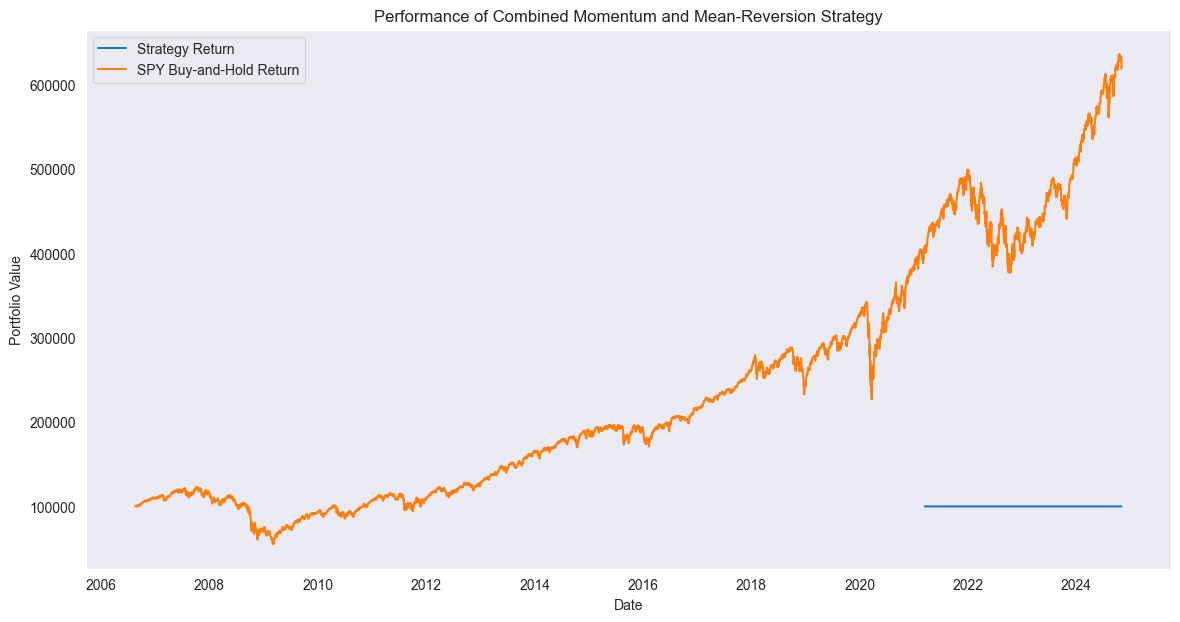

Final Strategy Portfolio Value: $100,000.00
Final SPY Buy-and-Hold Portfolio Value: $618,837.10

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         7
         0.0       0.96      1.00      0.98       881
         1.0       0.00      0.00      0.00        29

    accuracy                           0.96       917
   macro avg       0.32      0.33      0.33       917
weighted avg       0.92      0.96      0.94       917



In [15]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Download historical SPY data for the last 20 years
ticker = "SPY"
start_date = "2005-11-01"
end_date = "2024-11-1"
data = yf.download(ticker, start=start_date, end=end_date)

# Forward-fill missing values
data.fillna(method="ffill", inplace=True)

# Add momentum indicators
data['MA50'] = data['Adj Close'].rolling(window=50).mean()
data['MA200'] = data['Adj Close'].rolling(window=200).mean()
data['MomentumSignal'] = 0
data.loc[data['MA50'] > data['MA200'], 'MomentumSignal'] = 1  # Bullish
data.loc[data['MA50'] < data['MA200'], 'MomentumSignal'] = -1  # Bearish

# Add mean-reversion indicators
data['MiddleBand'] = data['Adj Close'].rolling(window=20).mean()
data['StdDev'] = data['Adj Close'].rolling(window=20).std()
data['UpperBand'] = data['MiddleBand'] + (data['StdDev'] * 2)
data['LowerBand'] = data['MiddleBand'] - (data['StdDev'] * 2)
data['MeanRevSignal'] = 0
data.loc[data['Adj Close'] < data['LowerBand'], 'MeanRevSignal'] = 1  # Oversold
data.loc[data['Adj Close'] > data['UpperBand'], 'MeanRevSignal'] = -1  # Overbought

# Combine signals
data['CompositeSignal'] = data['MomentumSignal'] + data['MeanRevSignal']

# Generate trading signal
data['TradingSignal'] = 0
data.loc[data['CompositeSignal'] >= 2, 'TradingSignal'] = 1  # Strong Buy
data.loc[data['CompositeSignal'] <= -2, 'TradingSignal'] = -1  # Strong Sell

# Remove rows with NaN values caused by rolling calculations
data.dropna(inplace=True)

# Create features and target variable
data['Target'] = data['TradingSignal'].shift(-1)  # Predict the next day's signal
features = ['MomentumSignal', 'MeanRevSignal', 'CompositeSignal']
X = data[features]
y = data['Target']
y = y.fillna(0)  # Replace NaN target values with 0

# Split data into training (80%) and testing (20%) sets
train_size = int(len(data) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=5)
model.fit(X_train, y_train)

# Predict trading signals on the test set
y_pred = model.predict(X_test)
data.loc[X_test.index, 'PredictedSignal'] = y_pred

# Backtest the strategy
initial_capital = 100000
data['Position'] = data['PredictedSignal'].shift(1)  # Position for each day
data['DailyReturn'] = data['Position'] * data['Adj Close'].pct_change()
data['CumulativeReturn'] = (1 + data['DailyReturn']).cumprod() * initial_capital

# Calculate benchmark performance (SPY buy-and-hold)
data['SPY_CumulativeReturn'] = (1 + data['Adj Close'].pct_change()).cumprod() * initial_capital

# Plot the performance
plt.figure(figsize=(14, 7))
plt.plot(data['CumulativeReturn'], label='Strategy Return')
plt.plot(data['SPY_CumulativeReturn'], label='SPY Buy-and-Hold Return')
plt.title('Performance of Combined Momentum and Mean-Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

# Print final portfolio value
final_strategy_value = data['CumulativeReturn'].iloc[-1]
final_spy_value = data['SPY_CumulativeReturn'].iloc[-1]
print(f"Final Strategy Portfolio Value: ${final_strategy_value:,.2f}")
print(f"Final SPY Buy-and-Hold Portfolio Value: ${final_spy_value:,.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[*********************100%%**********************]  1 of 1 completed


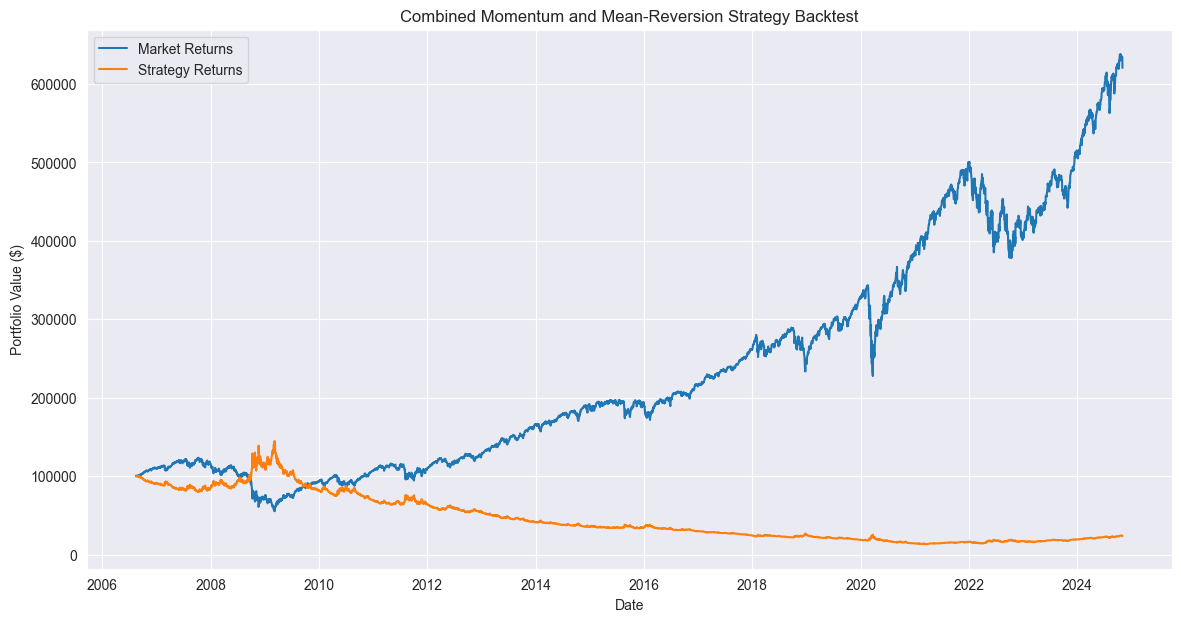

Final Portfolio Value (Strategy): $23,727.44
Final Portfolio Value (Market): $620,411.41
Strategy CAGR: -7.61%
Market CAGR: 10.56%


In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Parameters
ticker = 'SPY'
start_date = "2005-11-01"
end_date = "2024-11-1"
initial_capital = 100000

# Download historical data
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate returns
data['Returns'] = data['Adj Close'].pct_change()

# Momentum Indicator: 50-day and 200-day Moving Averages
data['MA50'] = data['Adj Close'].rolling(window=50).mean()
data['MA200'] = data['Adj Close'].rolling(window=200).mean()
data['MomentumSignal'] = np.where(data['MA50'] > data['MA200'], 1, -1)

# Mean-Reversion Indicator: Bollinger Bands
data['MiddleBand'] = data['Adj Close'].rolling(window=20).mean()
data['StdDev'] = data['Adj Close'].rolling(window=20).std()
data['UpperBand'] = data['MiddleBand'] + (data['StdDev'] * 2)
data['LowerBand'] = data['MiddleBand'] - (data['StdDev'] * 2)
data['MeanRevSignal'] = 0
data.loc[data['Adj Close'] < data['LowerBand'], 'MeanRevSignal'] = 1
data.loc[data['Adj Close'] > data['UpperBand'], 'MeanRevSignal'] = -1

# Drop NaN rows due to rolling calculations
data.dropna(inplace=True)

# Create features and target
features = ['Returns', 'MomentumSignal', 'MeanRevSignal']
data['Target'] = np.where(data['Adj Close'].shift(-1) > data['Adj Close'], 1, 0)
X = data[features]
y = data['Target']

# Train-test split (80% train, 20% backtest)
train_size = int(len(data) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Train supervised machine learning model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
Y_pred = model.predict(X_test)
data.loc[X_test.index, 'Y_pred'] = Y_pred

# Strategy signals combining momentum and mean reversion
data['CombinedSignal'] = data['Y_pred'] + data['MomentumSignal'] + data['MeanRevSignal']

# Generate trading signals
data['TradingSignal'] = np.where(data['CombinedSignal'] > 0, 1, -1)

# Backtesting
data['Position'] = data['TradingSignal'].shift(1)
data['StrategyReturns'] = data['Position'] * data['Returns']
data['CumulativeMarketReturns'] = (1 + data['Returns']).cumprod() * initial_capital
data['CumulativeStrategyReturns'] = (1 + data['StrategyReturns']).cumprod() * initial_capital

# Plot results
plt.figure(figsize=(14, 7))
plt.plot(data['CumulativeMarketReturns'], label='Market Returns')
plt.plot(data['CumulativeStrategyReturns'], label='Strategy Returns')
plt.title('Combined Momentum and Mean-Reversion Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

# Performance metrics
final_strategy_value = data['CumulativeStrategyReturns'].iloc[-1]
final_market_value = data['CumulativeMarketReturns'].iloc[-1]
strategy_cagr = (final_strategy_value / initial_capital) ** (1 / (len(data) / 252)) - 1
market_cagr = (final_market_value / initial_capital) ** (1 / (len(data) / 252)) - 1

print(f"Final Portfolio Value (Strategy): ${final_strategy_value:,.2f}")
print(f"Final Portfolio Value (Market): ${final_market_value:,.2f}")
print(f"Strategy CAGR: {strategy_cagr:.2%}")
print(f"Market CAGR: {market_cagr:.2%}")


In [13]:
data

,Open,High,Low,Close,Adj Close,Volume,Returns,MA50,MA200,MomentumSignal,...,LowerBand,MeanRevSignal,Target,Y_pred,CombinedSignal,TradingSignal,Position,StrategyReturns,CumulativeMarketReturns,CumulativeStrategyReturns
Date,,,,,,,,,,,,,,,,,,,,,
2003-10-16,104.680000,105.730003,104.650002,105.410004,70.889580,32772200,0.004000,68.405145,63.107576,1,...,66.872426,0,0,NaN,NaN,-1,NaN,NaN,100400.038165,NaN
2003-10-17,105.470001,105.629997,103.980003,104.260002,70.116196,32790300,-0.010910,68.494385,63.155418,1,...,66.871312,0,1,NaN,NaN,-1,-1.0,0.010910,99304.703804,101090.970065
2003-10-20,104.449997,105.040001,103.940002,105.040001,70.640739,27657000,0.007481,68.590364,63.204952,1,...,66.891755,0,0,NaN,NaN,-1,-1.0,-0.007481,100047.608669,100334.702026
2003-10-21,104.820000,105.279999,104.320000,104.860001,70.519669,26729100,-0.001714,68.678964,63.248529,1,...,66.908963,0,0,NaN,NaN,-1,-1.0,0.001714,99876.137500,100506.665244
2003-10-22,104.029999,104.190002,103.190002,103.540001,69.631981,33914500,-0.012588,68.737751,63.288431,1,...,67.085453,0,0,NaN,NaN,-1,-1.0,0.012588,98618.916374,101771.823328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,379.649994,383.059998,378.029999,382.910004,373.653931,59857300,0.005752,376.944230,387.680313,-1,...,366.600636,0,0,0.0,-1.0,-1,-1.0,-0.005752,529201.456959,21856.689653
2022-12-27,382.790009,383.149994,379.649994,381.399994,372.180420,51638200,-0.003944,377.440043,387.524357,-1,...,365.321958,0,0,0.0,-1.0,-1,-1.0,0.003944,527114.541855,21942.881887
2022-12-28,381.329987,383.390015,376.420013,376.660004,367.554962,70911500,-0.012428,377.664810,387.360014,-1,...,363.302562,0,1,0.0,-1.0,-1,-1.0,0.012428,520563.563030,22215.587994


[*********************100%%**********************]  1 of 1 completed


Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       159
           0       0.78      0.93      0.85       689
           1       0.63      0.74      0.68       104

    accuracy                           0.76       952
   macro avg       0.80      0.56      0.52       952
weighted avg       0.80      0.76      0.69       952


Performance Metrics:
Total Strategy Return: 12.79%
Total Market Return: 61.38%
Strategy Annualized Return: 3.24%
Market Annualized Return: 13.50%
Strategy Annualized Volatility: 7.28%
Market Annualized Volatility: 16.63%
Strategy Sharpe Ratio: 0.47
Market Sharpe Ratio: 0.84


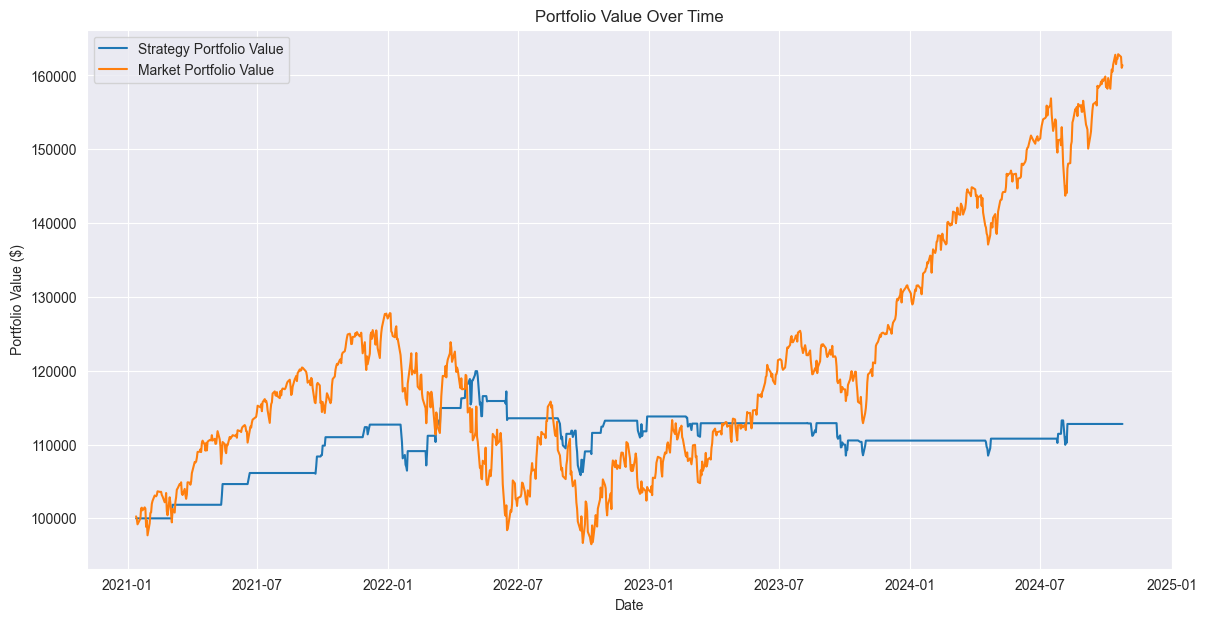

In [17]:
# Mean-Reversion Strategy on SPY using Supervised Machine Learning
# Author: [Your Name]
# Date: [Current Date]

# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Download SPY data for the last 20 years
start_date = "2005-11-01"
end_date = "2024-11-1"

data = yf.download('SPY', start=start_date, end=end_date)

# Calculate technical indicators and features
data['Returns'] = data['Adj Close'].pct_change()

# Moving Averages
data['SMA5'] = data['Adj Close'].rolling(window=5).mean()
data['SMA10'] = data['Adj Close'].rolling(window=10).mean()
data['SMA20'] = data['Adj Close'].rolling(window=20).mean()

# Standard Deviation
data['STD20'] = data['Adj Close'].rolling(window=20).std()

# Bollinger Bands
data['UpperBB'] = data['SMA20'] + 2 * data['STD20']
data['LowerBB'] = data['SMA20'] - 2 * data['STD20']

# Z-Score
data['Z-score'] = (data['Adj Close'] - data['SMA20']) / data['STD20']

# RSI Calculation
def calculate_RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    gain = up.rolling(window=period).mean()
    loss = down.rolling(window=period).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

data['RSI'] = calculate_RSI(data['Adj Close'])

# Drop NaN values
data.dropna(inplace=True)

# Create target variable based on future returns
n = 5  # Number of days to look ahead
data['Future Returns'] = data['Adj Close'].shift(-n) / data['Adj Close'] - 1

# Define target variable for mean-reversion
conditions = [
    (data['Z-score'] > 1) & (data['Future Returns'] < 0),
    (data['Z-score'] < -1) & (data['Future Returns'] > 0)
]
choices = [-1, 1]
data['Target'] = np.select(conditions, choices, default=0)

# Remove any remaining NaN values
data.dropna(inplace=True)

# Split data into training (80%) and testing (20%)
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Define features and target variable
features = ['SMA5', 'SMA10', 'SMA20', 'RSI', 'Z-score', 'UpperBB', 'LowerBB', 'STD20']
X_train = train_data[features]
y_train = train_data['Target']

X_test = test_data[features]
y_test = test_data['Target']

# Train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Implement the trading strategy
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Position'] = y_pred

# Shift positions to avoid look-ahead bias
test_data['Position'] = test_data['Position'].shift(1)
test_data['Position'].fillna(0, inplace=True)

# Calculate strategy returns
test_data['Strategy Returns'] = test_data['Position'] * test_data['Returns']

# Calculate cumulative returns
test_data['Cumulative Strategy Returns'] = (1 + test_data['Strategy Returns']).cumprod()
test_data['Cumulative Market Returns'] = (1 + test_data['Returns']).cumprod()

# Simulate trading with initial capital of $100,000
initial_capital = 100000
test_data['Portfolio Value'] = initial_capital * test_data['Cumulative Strategy Returns']
test_data['Market Value'] = initial_capital * test_data['Cumulative Market Returns']

# Calculate performance metrics
total_return = test_data['Portfolio Value'].iloc[-1] / initial_capital - 1
market_return = test_data['Market Value'].iloc[-1] / initial_capital - 1

test_period_days = (test_data.index[-1] - test_data.index[0]).days
test_period_years = test_period_days / 365.25

# Annualized returns
strategy_annual_return = (1 + total_return) ** (1 / test_period_years) - 1
market_annual_return = (1 + market_return) ** (1 / test_period_years) - 1

# Annualized volatility
strategy_annual_volatility = test_data['Strategy Returns'].std() * np.sqrt(252)
market_annual_volatility = test_data['Returns'].std() * np.sqrt(252)

# Sharpe Ratio (assuming risk-free rate is 0)
strategy_sharpe_ratio = (test_data['Strategy Returns'].mean() / test_data['Strategy Returns'].std()) * np.sqrt(252)
market_sharpe_ratio = (test_data['Returns'].mean() / test_data['Returns'].std()) * np.sqrt(252)

# Output performance metrics
print("\nPerformance Metrics:")
print(f"Total Strategy Return: {total_return:.2%}")
print(f"Total Market Return: {market_return:.2%}")
print(f"Strategy Annualized Return: {strategy_annual_return:.2%}")
print(f"Market Annualized Return: {market_annual_return:.2%}")
print(f"Strategy Annualized Volatility: {strategy_annual_volatility:.2%}")
print(f"Market Annualized Volatility: {market_annual_volatility:.2%}")
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
print(f"Market Sharpe Ratio: {market_sharpe_ratio:.2f}")

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(test_data['Portfolio Value'], label='Strategy Portfolio Value')
plt.plot(test_data['Market Value'], label='Market Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()
